In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, kstest

In [25]:
df = pd.read_csv("modified_QUANTT_dataset.csv")

In [26]:
data = df[['Stock price','Strike price','T','Risk-Free Rate','Volatility']]
targets = df['Average Value']

In [27]:
X_train, X_test, y_train, y_test  = train_test_split(data, targets, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle=True)

Epoch 1/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 25.7156 - val_loss: 28.8428
Epoch 2/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.2935 - val_loss: 28.5923
Epoch 3/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.3957 - val_loss: 28.3769
Epoch 4/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.0089 - val_loss: 28.1551
Epoch 5/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.5292 - val_loss: 27.9480
Epoch 6/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.1015 - val_loss: 27.7336
Epoch 7/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.1603 - val_loss: 27.5180
Epoch 8/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.1848 - val_loss: 27.2881
Epoch 9/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.5380 - val_loss: 27.0748
Epoch 10/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.1554 - val_loss: 26.8720
Epoch 11/10000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.8090 - val_loss: 26.6705
Epoch 12/10000
17

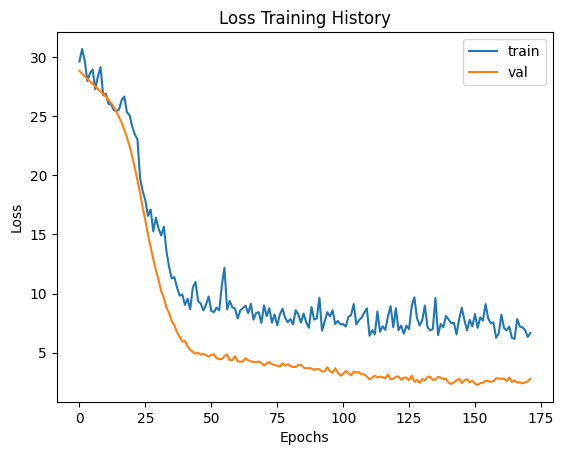

In [30]:

input1 = Input(shape=(X_train.shape[1],), name='input')
normalized_input = BatchNormalization()(input1)

ann_layer1 = Dense(16, activation='relu')(normalized_input)
dropout = Dropout(0.1)(ann_layer1)  
ann_layer2 = Dense(16, activation='relu')(dropout)
dropout2 = Dropout(0.1)(ann_layer2)  

output_layer = Dense(1, activation='relu')(dropout2)

model = tf.keras.Model(inputs=input1, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="MAE", metrics=[])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.01, start_from_epoch=100)

history = model.fit(X_train, y_train, epochs=10000, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


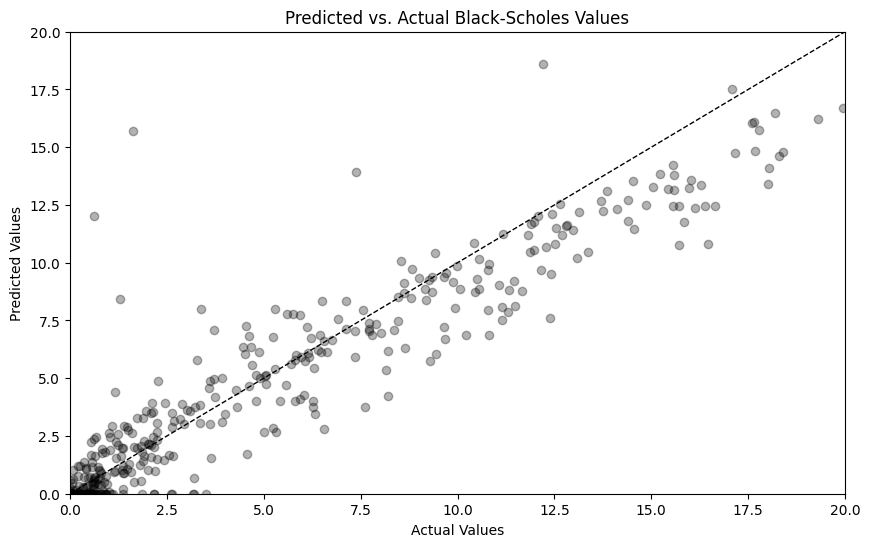

In [51]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Visualizing the predictions against the actual Black-Scholes values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='k', alpha=0.3)
plt.title('Predicted vs. Actual Black-Scholes Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.ylim((0,20))
plt.xlim((0,20))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)  # Diagonal line for reference
plt.show()


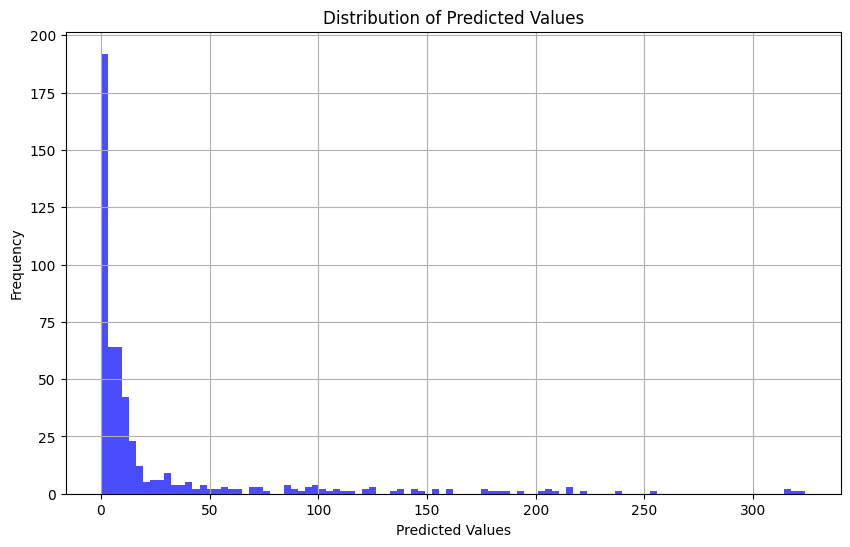

In [45]:
y_pred_flat = y_pred.flatten()

# Plotting the distribution of y_pred
plt.figure(figsize=(10, 6))
plt.hist(y_pred_flat, bins=100, alpha=0.7, color='blue')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()